In [1]:
import keras 
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from PIL import Image
from imutils import paths
from os import path
from keras.optimizers import Adam,RMSprop
import pandas as pd
keras.__version__
IMAGE_DIMS = (375,250,3)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

In [3]:
date_arr = np.load('./new_date_arr.npy',allow_pickle=True)
test_arr = np.load('./new_test_date.npy',allow_pickle=True)
dust_arr = np.load('./PM_avg_11.npy',allow_pickle=True)
wind_arr = np.load('./wind_arr.npy',allow_pickle=True)
humi_arr = np.load('./humi_arr.npy',allow_pickle=True)
filter_index = np.load('./dataset/value/new_date_arr_PM10-1.npy',allow_pickle=True)

print(filter_index)



[202009141248 202008051718 202009182216 ... 202008190954 202009141228
 202008141806]


In [4]:
import time

new_date_arr = []
new_dust_arr = []
new_wind_arr = []
new_humi_arr = []

start = time.time() 
imagePaths = sorted(list(paths.list_images('./dataset/image')))
image_arr = []

for i in imagePaths:
    img_name = int(path.splitext(path.basename(i))[0])

    if img_name in date_arr :
        for j in filter_index:
            
            if str(j) in str(img_name):
                if img_name in test_arr:
                    k = np.where(date_arr==img_name)[0][0]
                    new_date_arr.append(date_arr[k])
                    new_dust_arr.append(dust_arr[k])
                    new_wind_arr.append(wind_arr[k])
                    new_humi_arr.append(humi_arr[k])

                    image = Image.open(i)
                    image_crop = image.crop([380,0,600,200])
                    image_crop = image_crop.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
                    image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
                    image = np.concatenate((image_crop,image),axis=2)
                    image = img_to_array(image)
                    image_arr.append(image)
image_arr = np.array(image_arr, dtype="float") / 255.0    

print("[INFO] data matrix:  ({:.2f}MB)".format(image_arr.nbytes / (1024 * 1000.0)))


[INFO] data matrix:  (408.69MB)


In [5]:
print(len(new_date_arr))
print(len(new_dust_arr))
print(len(new_wind_arr))
print(len(new_humi_arr))

print(len(image_arr))

93
93
93
93
93


In [6]:
from sklearn.utils import shuffle

con_data_img = image_arr
con_data_val = new_dust_arr
con_data_wea = np.concatenate([np.array(new_wind_arr).reshape(len(new_wind_arr),1),
                                   np.array(new_humi_arr).reshape(len(new_humi_arr),1)], axis=1)

con_data_img, con_data_val, con_data_wea = shuffle(np.array(con_data_img), np.array(con_data_val), np.array(con_data_wea), random_state=0)



In [7]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, GRU, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

model= keras.models.load_model('lstm-roi-PM-200-11.model')
y_pred = np.squeeze(np.round(model.predict([con_data_img, con_data_wea]).astype(np.int64)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
RMSE = mean_squared_error(con_data_val.astype(np.int64), y_pred)**0.5
R2SCORE = r2_score(con_data_val.astype(np.int64), y_pred)

print("RMSE 는 : " , RMSE)
print("R2SCORE 는 : ", R2SCORE)

RMSE 는 :  7.624944914308336
R2SCORE 는 :  0.9482246607658925


Text(70, 50, 'R-squared = 0.95')

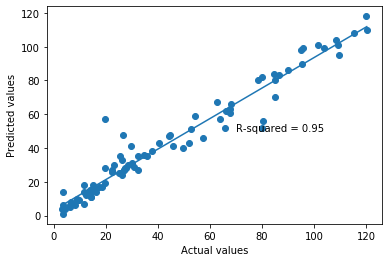

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

test_val=np.squeeze(con_data_val.astype(np.int64))

plt.scatter(con_data_val,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(con_data_val), np.poly1d(np.polyfit(con_data_val, y_pred, 1))(np.unique(con_data_val)))

plt.text(70, 50, 'R-squared = %0.2f' % R2SCORE)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
i=100

plt.imshow(con_data_img[i][:,:,3:])
print("예측값 : ", y_pred[i])
print("실제값 : ", con_data_val[i])

IndexError: index 100 is out of bounds for axis 0 with size 93